In [1]:
%reset-f


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np

import matplotlib.pyplot as plt
from res_ind_lib import *

from maps_lib import *
import pandas as pd

import warnings
warnings.filterwarnings("always",category=UserWarning)

from IPython.display import Image

### Data

In [3]:
bin_colors = True

In [4]:
#Get resilience, country name, and iso2
df = pd.read_csv('results/df.csv').dropna()#.set_index("iso3")

df["logrisk"] = np.log10(df.risk)
df["log_risk_to_assets"] = np.log10(df.risk_to_assets)

color = pd.DataFrame(index=df.index)

if bin_colors:
    
    bins_data =pd.read_csv("map/bin_map.csv", index_col="key")
    for k in bins_data.index:
        color[k] = pd.cut(df[k], eval(bins_data["bins"][k]), labels=eval(bins_data["colors"][k]))
    
else:
    color["resilience"]=data_to_rgb(df.resilience, plt.cm.get_cmap("Reds_r"))
    color["risk"]=data_to_rgb(df.risk,plt.cm.get_cmap("Purples"))
    color["logrisk"]=data_to_rgb(df.logrisk,plt.cm.get_cmap("Purples"))
    color["risk_to_assets"]=data_to_rgb(df.risk_to_assets,plt.cm.get_cmap("Blues"))

### Export map data

In [5]:
a=pd.concat([df[["country"]+color.columns.tolist()],color.rename(columns=lambda s:s+"_color")],axis=1)
a.to_csv('map/data_for_map.csv')
a.head()

,country,resilience,risk,risk_to_assets,resilience_color,risk_color,risk_to_assets_color
0,Albania,0.71021,0.01186,0.00842,#fcae91,#756bb1,#08519c
1,Argentina,0.52881,0.00211,0.00111,#fb6a4a,#9e9ac8,#6baed6
2,Armenia,0.69078,0.00134,0.00092,#fcae91,#9e9ac8,#6baed6
3,Australia,0.71335,0.00076,0.00054,#fcae91,#9e9ac8,#6baed6
4,Austria,0.69237,0.00014,0.00010,#fcae91,#f2f0f7,#eff3ff


### Map

In [6]:
style_base =\
""".{iso2}
{{  
   fill: {color};
   stroke:#666666;
   stroke-width:0.3;
   fill-rule:evenodd;
}}"""

styles_rk = styles_rl=styles_r=styles=""
for c in df.index:
    styles = styles     + style_base.format(iso2=df["iso3"][c],color=color["resilience"][c])+ "\n"
#     styles_r = styles_r + style_base.format(iso2=df["iso2"][c].lower(),color=df["risk_color"][c])+ "\n"
    styles_rl = styles_rl + style_base.format(iso2=df["iso3"][c],color=color["risk"][c])+ "\n"
    styles_rk = styles_rk + style_base.format(iso2=df["iso3"][c],color=color["risk_to_assets"][c])+ "\n"
    
append_styles_to_map("img/map_of_resilience",styles, inmap="map/Blank world map with simplified WB boundaries.svg")
# append_styles_to_map("of_risk",styles_r)
append_styles_to_map("img/map_of_log_risk",styles_rl, inmap="map/Blank world map with simplified WB boundaries.svg")
append_styles_to_map("img/map_of_log_risk_to_assets",styles_rk, inmap="map/Blank world map with simplified WB boundaries.svg")

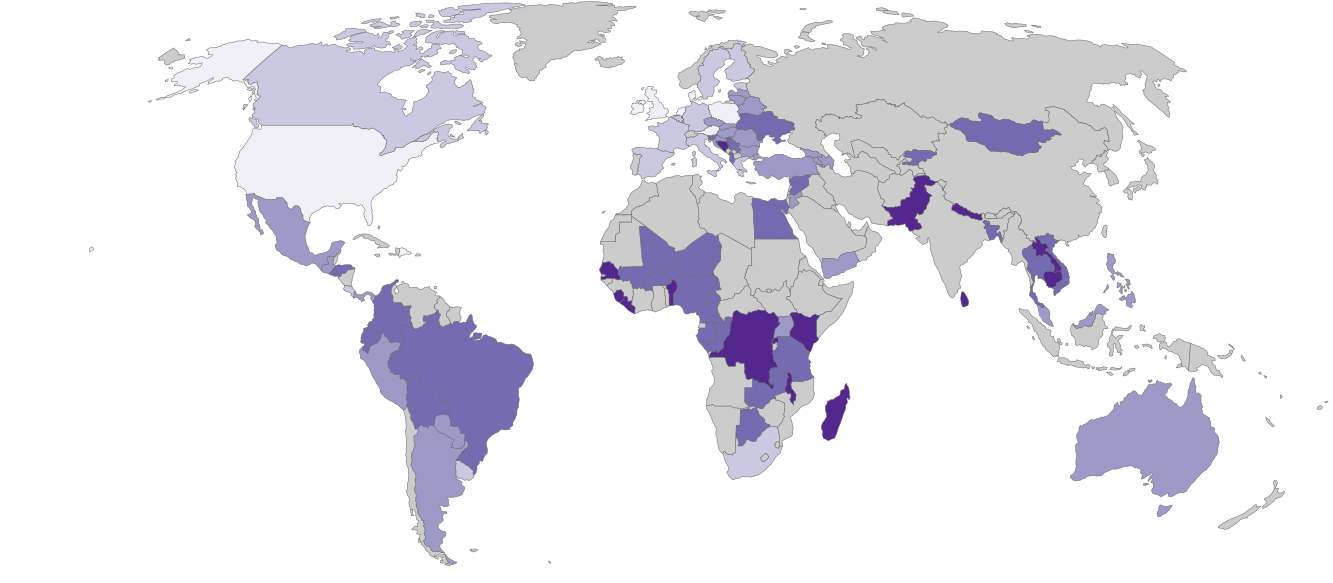

In [7]:
Image("img/map_of_log_risk.png")

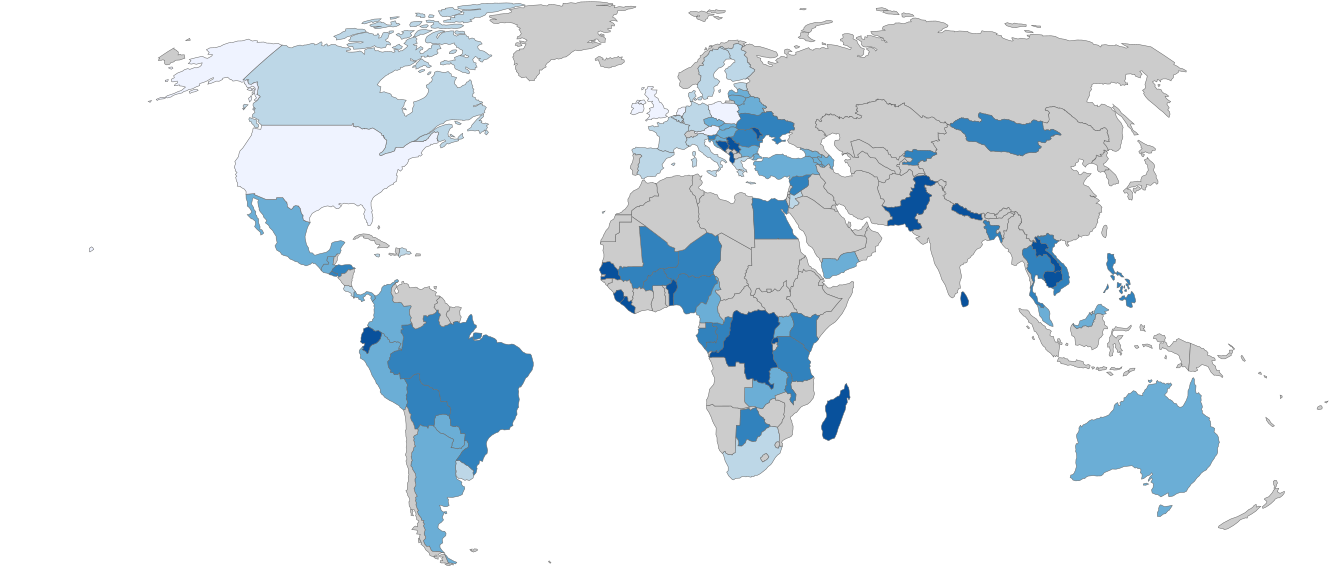

In [8]:
Image("img/map_of_log_risk_to_assets.png")

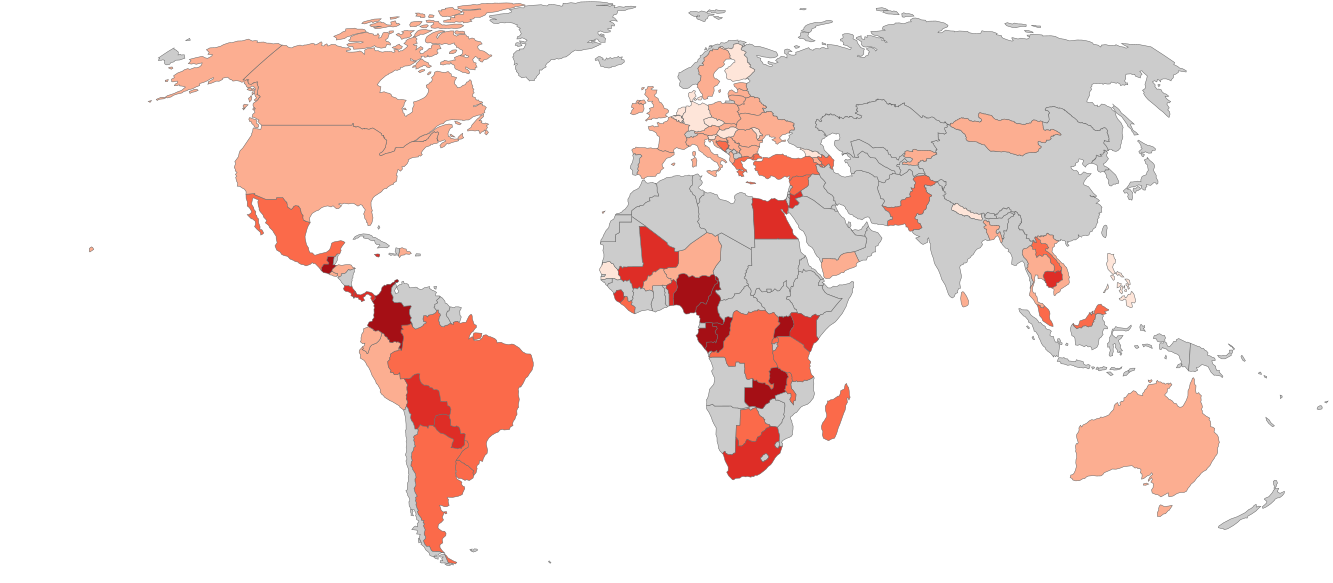

In [9]:
Image("img/map_of_resilience.png")

# Legend

In [10]:
font = {'family' : 'sans serif',
    'size'   : 22}



plt.rc('font', **font)
plt.rcParams["savefig.dpi"]=90

# Legend of Resilience

## Legend from bins

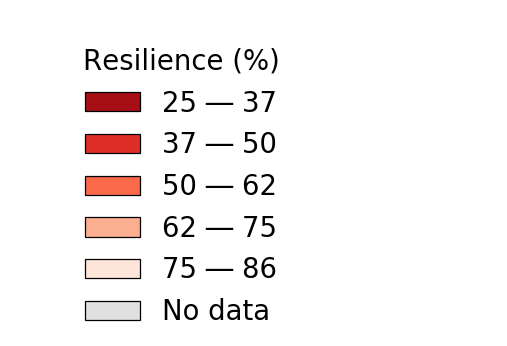

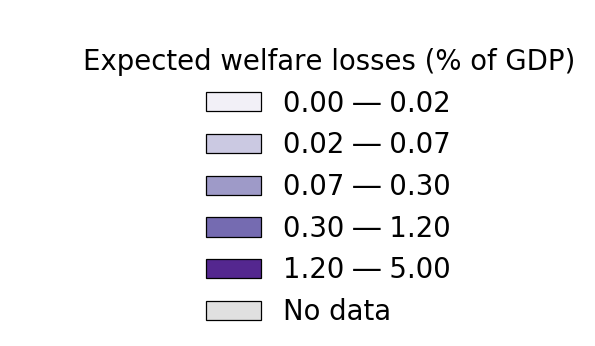

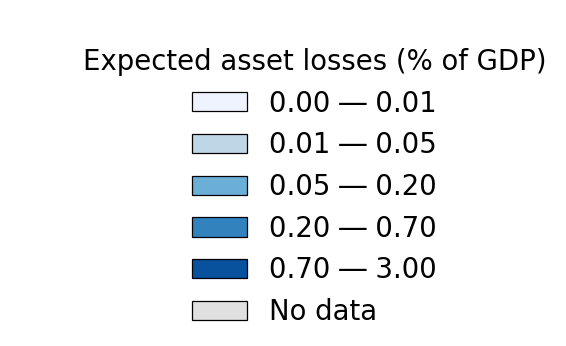

In [11]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
from fancy_round import *


for k in bins_data.index:
    bins = eval(bins_data["bins"][k])
    colors = eval(bins_data["colors"][k])
    label = bins_data["label"][k]
  
    patches =[]
    for i in np.arange(len(colors)):
        patches+=[mpatches.Patch( fc=colors[i], 
                    label=("{m:.0f} — {M:.0f}" if k=="resilience" else "{m:.2f} — {M:.2f}").format(m=100*bins[i],M=100*bins[i+1])
                        )]

    
    patches+=[mpatches.Patch( fc="#e0e0e0", 
                    label="No data"
                        )]
    
    plt.figure()
    ax=plt.gca()

    ax.legend(handles=patches, loc="upper left", prop=font,frameon=False, title=label)  

    ax.axis('off')

    plt.savefig("img/legend_of_"+k, bbox_inches="tight", transparent=True)